## Code for preprocessing steps of the raw dataset

### Only including entries for town "GEYLANG"

In [13]:
import pandas as pd

input_file_path = "../data/raw/ALL_Prices_1990_2021_mar.csv"
output_file_path = "../data/processed/bedok_processed.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file_path)

# Filter the DataFrame for entries where the town is "BEDOK"
df_bedok = df[df["town"] == "GEYLANG"].copy()

# Create a timestamp column by converting the "month" column to datetime.
df_bedok["timestamp"] = pd.to_datetime(df_bedok["month"], format="%Y-%m")

# Select only the necessary columns: the timestamp and the price per square meter
df_bedok = df_bedok[["timestamp", "price_psm"]]

# Set the timestamp column as the DataFrame index for resampling
df_bedok.set_index("timestamp", inplace=True)

# Aggregate the data to get mean, 5th percentile, and 95th percentile per month
df_monthly = df_bedok.resample("MS").agg({
    "price_psm": ["mean", lambda x: x.quantile(0.05), lambda x: x.quantile(0.95)]
})

# Rename columns for clarity
df_monthly.columns = ["price_psm", "5th_percentile", "95th_percentil"]

# Reset the index so that timestamp is a column again
df_monthly.reset_index(inplace=True)

# Save the aggregated monthly data to a new CSV file in the preprocessed folder
df_monthly.to_csv(output_file_path, index=False, date_format="%Y-%m")

print(f"Preprocessed data saved to {output_file_path}")

Preprocessed data saved to ../data/processed/bedok_processed.csv


In [14]:
df_monthly.tail()

,timestamp,price_psm,5th_percentile,95th_percentil
370,2020-11-01,5621.706822,4004.310345,8104.838710
371,2020-12-01,5339.820288,3698.629169,8112.685266
372,2021-01-01,5550.876649,3875.839552,7982.313433
373,2021-02-01,5586.541965,3973.782051,7994.623656
374,2021-03-01,5241.377099,3946.561771,7937.381404


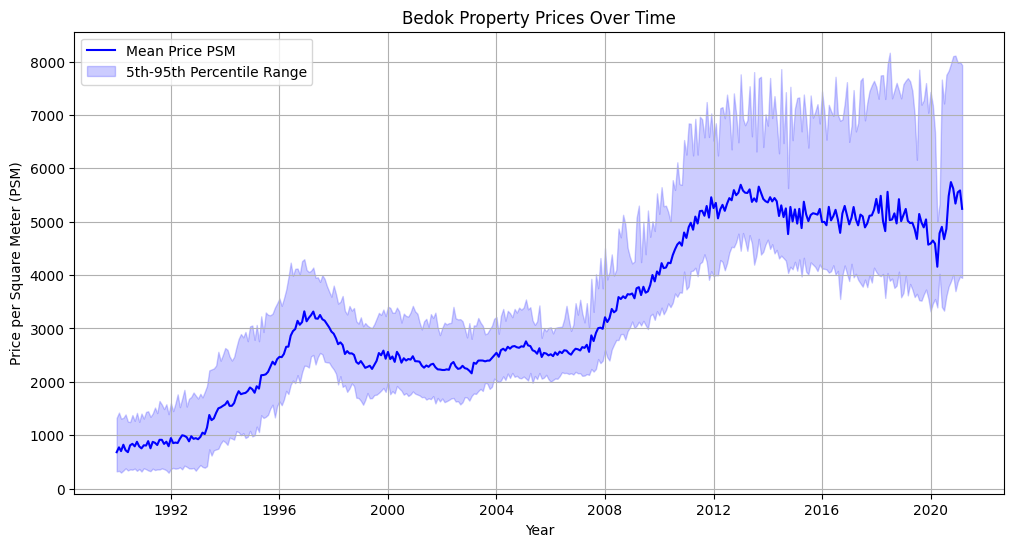

In [15]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_monthly["timestamp"], df_monthly["price_psm"], label="Mean Price PSM", color="blue")
plt.fill_between(df_monthly["timestamp"], df_monthly["5th_percentile"], df_monthly["95th_percentil"], 
                 color="blue", alpha=0.2, label="5th-95th Percentile Range")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Price per Square Meter (PSM)")
plt.title("Bedok Property Prices Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Fitting ARIMA(2,1,2) model to predict prices of last 10% of data set. Also calculate simmple error measurements and plot all together

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume df_monthly is already loaded and has a datetime index.
# It has three columns: "price_psm", "5th_percentile", "95th_percentil"
# If your datetime column is not set as the index, do so here:
# df_monthly["timestamp"] = pd.to_datetime(df_monthly["timestamp"])
# df_monthly.set_index("timestamp", inplace=True)

# Split the data: 90% for training, 10% for testing
split_index = int(len(df_monthly) * 0.80)
train = df_monthly.iloc[:split_index]
test = df_monthly.iloc[split_index:]

# Fit the ARIMA(2,1,2) model on the training data's "price_psm"
model = ARIMA(train["price_psm"], order=(2, 1, 2))
model_fit = model.fit()

# Forecast for the entire test period
forecast = model_fit.forecast(steps=len(test))


c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [17]:

# Calculate error metrics: Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(test["price_psm"], forecast)
mae = mean_absolute_error(test["price_psm"], forecast)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 147032.19280962044
Mean Absolute Error (MAE): 312.7567633736601


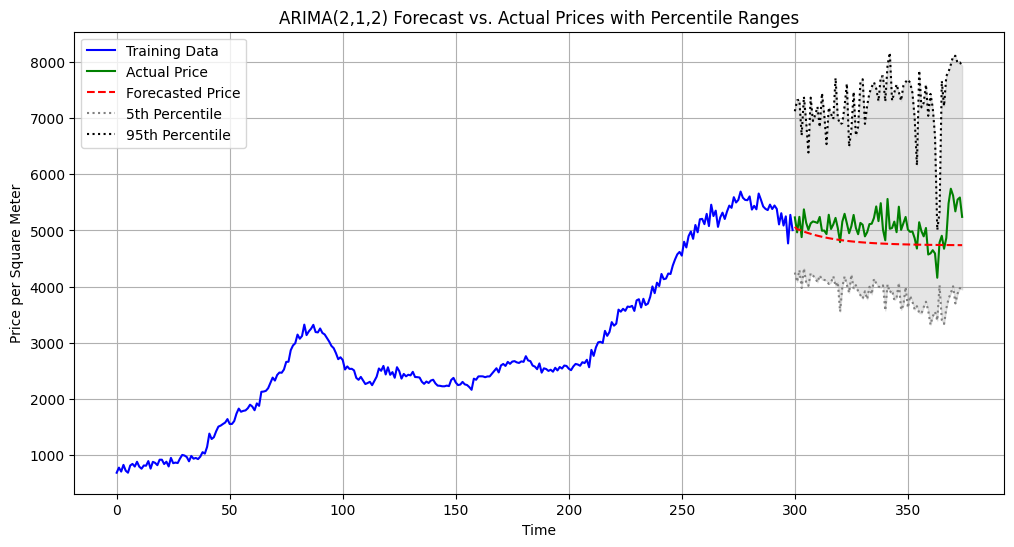

In [18]:

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the training and test actual values
plt.plot(train.index, train["price_psm"], label="Training Data", color="blue")
plt.plot(test.index, test["price_psm"], label="Actual Price", color="green")

# Plot the forecasted values
plt.plot(test.index, forecast, label="Forecasted Price", color="red", linestyle="--")

# Plot the percentile lines for the test period
plt.plot(test.index, test["5th_percentile"], label="5th Percentile", color="grey", linestyle=":")
plt.plot(test.index, test["95th_percentil"], label="95th Percentile", color="black", linestyle=":")

# Shade the area between the 5th and 95th percentiles
plt.fill_between(test.index, test["5th_percentile"], test["95th_percentil"], color="grey", alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Price per Square Meter")
plt.title("ARIMA(2,1,2) Forecast vs. Actual Prices with Percentile Ranges")
plt.legend()
plt.grid(True)
plt.show()


## SARIMA MODEL

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume df_monthly is already loaded and has the following columns:
# "price_psm", "5th_percentile", "95th_percentil"
# Also, assume that df_monthly has a datetime index.
# If not, convert and set the index:
# df_monthly["timestamp"] = pd.to_datetime(df_monthly["timestamp"])
# df_monthly.set_index("timestamp", inplace=True)

# Split the dataset: 90% training, 10% testing
split_index = int(len(df_monthly) * 0.80)
train = df_monthly.iloc[:split_index]
test = df_monthly.iloc[split_index:]

# Fit SARIMA model with non-seasonal order (2,1,2) and seasonal order (1,1,1,12)
model = SARIMAX(train["price_psm"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test))


c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [20]:

# Calculate error metrics: Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(test["price_psm"], forecast)
mae = mean_absolute_error(test["price_psm"], forecast)
print("SARIMA Model MSE:", mse)
print("SARIMA Model MAE:", mae)


SARIMA Model MSE: 132053.96810443464
SARIMA Model MAE: 264.29580715348


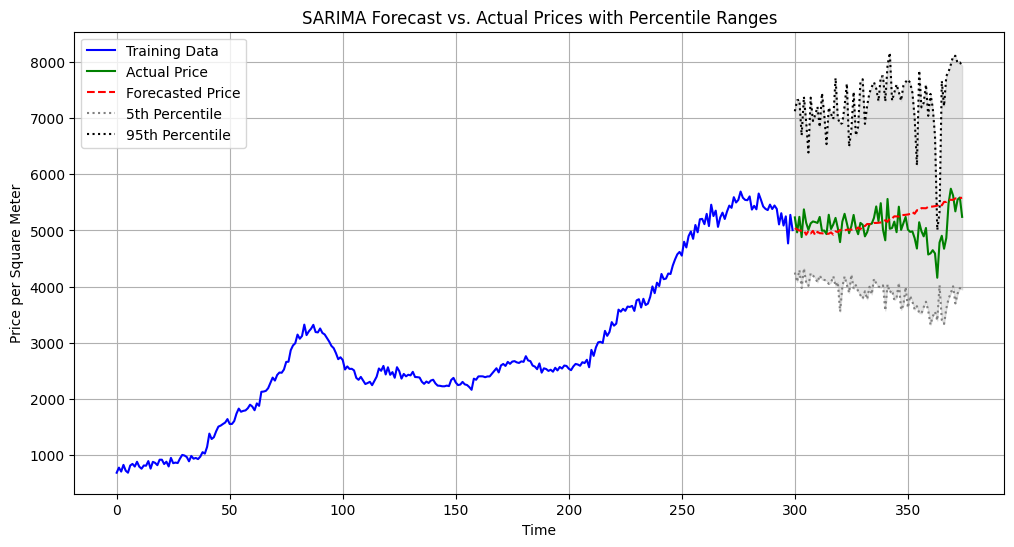

In [21]:

# Plot the actual prices, forecast, and percentile boundaries
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["price_psm"], label="Training Data", color="blue")
plt.plot(test.index, test["price_psm"], label="Actual Price", color="green")
plt.plot(test.index, forecast, label="Forecasted Price", color="red", linestyle="--")
plt.plot(test.index, test["5th_percentile"], label="5th Percentile", color="grey", linestyle=":")
plt.plot(test.index, test["95th_percentil"], label="95th Percentile", color="black", linestyle=":")
plt.fill_between(test.index, test["5th_percentile"], test["95th_percentil"], color="grey", alpha=0.2)
plt.xlabel("Time")
plt.ylabel("Price per Square Meter")
plt.title("SARIMA Forecast vs. Actual Prices with Percentile Ranges")
plt.legend()
plt.grid(True)
plt.show()


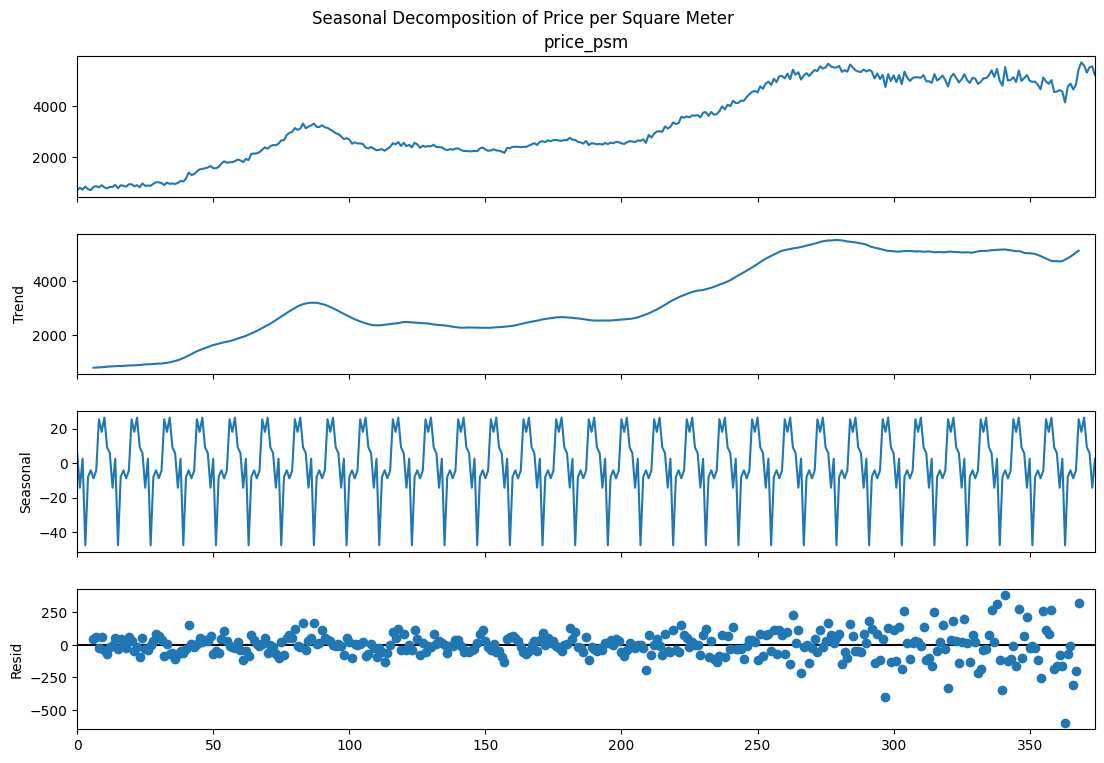

In [22]:

# Optional: Seasonal Decomposition to visualize the seasonal component
decomposition = sm.tsa.seasonal_decompose(df_monthly["price_psm"], model="additive", period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Price per Square Meter")
plt.show()


Log differences

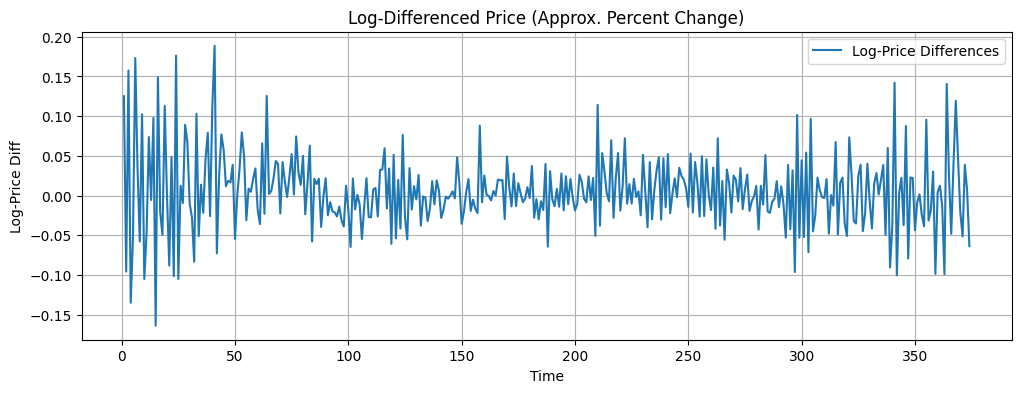

c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         log_price_diff   No. Observations:                  374
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 641.575
Date:                Thu, 20 Mar 2025   AIC                          -1275.149
Time:                        17:46:10   BIC                          -1259.452
Sample:                             0   HQIC                         -1268.917
                                - 374                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      3.476      0.001       0.002       0.008
ar.L1         -0.2686      0.104     -2.580      0.010      -0.473      -0.065
ma.L1         -0.1721      0.111     -1.555      0.1

c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mihaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Suppose you have a DataFrame 'df_monthly' with a column 'price_psm' and a DateTimeIndex.
# If not, ensure it's a time-series index:
# df_monthly["timestamp"] = pd.to_datetime(df_monthly["timestamp"])
# df_monthly.set_index("timestamp", inplace=True)

# 1. Log transform
df_monthly["log_price"] = np.log(df_monthly["price_psm"])

# 2. Difference of the logged values (approx. percent changes)
df_monthly["log_price_diff"] = df_monthly["log_price"].diff()

# Drop any NaN from the first diff
df_monthly.dropna(subset=["log_price_diff"], inplace=True)

# 3. Quick check of the transformed series
plt.figure(figsize=(12, 4))
plt.plot(df_monthly.index, df_monthly["log_price_diff"], label="Log-Price Differences")
plt.title("Log-Differenced Price (Approx. Percent Change)")
plt.xlabel("Time")
plt.ylabel("Log-Price Diff")
plt.legend()
plt.grid(True)
plt.show()

# 4. Fit an ARIMA model on the log-differenced series
#    Here, we might start with order=(1, 0, 1) because we've already manually differenced once.
model = ARIMA(df_monthly["log_price_diff"], order=(2, 0, 2))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# 5. Forecasting the log differences, then converting back (if needed)
#    For demonstration, let's forecast next 12 steps (one year if monthly data).
n_steps = 12
forecast_log_diff = model_fit.forecast(steps=n_steps)

# Convert log differences back to actual levels (cumulative sum of differences)
# You need the last known log price to "integrate" the differenced forecast.
last_log_price = df_monthly["log_price"].iloc[-1]

# We'll construct a cumulative sum of forecasted log differences:
forecast_log_prices = [last_log_price + forecast_log_diff.iloc[0]]
for i in range(1, n_steps):
    forecast_log_prices.append(forecast_log_prices[-1] + forecast_log_diff.iloc[i])

# Exponentiate to get back to the original price scale
forecast_prices = np.exp(forecast_log_prices)

# 6. Show results
print("Forecasted log differences:")
print(forecast_log_diff)
print("\nForecasted log prices:")
print(forecast_log_prices)
print("\nForecasted actual prices:")
print(forecast_prices)
